In [1]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

Added /nfs/home/cybai/PyTorch-StudioGAN/src to path
Added /nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch to path
Added /nfs/home/cybai/PyTorch-StudioGAN/data-copying to path
Added /nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10 to path


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

<module 'data_copying_tests' from '/nfs/home/cybai/PyTorch-StudioGAN/data-copying/data_copying_tests.py'>

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [4]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [8]:
feats = {}
for dset_name, dl in ref_dls.items():
    print(dset_name)
    feats_, logits_ = misc.project(dl, proj_model, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    feats[dset_name] = feats_

cifar10_1
cifar10_train
cifar10_test
cifair10


In [9]:
dset_inception_means, dset_inception_covs = {}, {}
for dset_name, feat in feats.items():
    dset_inception_means[dset_name] = np.mean(feat, axis=0)
    dset_inception_covs[dset_name] = np.cov(feat, rowvar=False)

In [9]:
nnds, _ = misc.calculate_knnd_numpy(target_feats=feats['cifar10_test'], 
                                    ref_feats=feats['cifar10_train'])
nnds.shape

(10000,)

(array([  7.,  18.,  28.,  17.,  33.,  27.,  39.,  53.,  66.,  97., 115.,
        157., 166., 252., 264., 316., 349., 375., 400., 415., 442., 457.,
        492., 548., 505., 528., 551., 560., 504., 479., 383., 352., 254.,
        232., 158., 122.,  85.,  64.,  29.,  27.,   8.,  12.,   4.,   3.,
          3.,   2.,   0.,   0.,   0.,   2.]),
 array([0.01536971, 0.02144039, 0.02751106, 0.03358173, 0.03965241,
        0.04572308, 0.05179375, 0.05786443, 0.0639351 , 0.07000577,
        0.07607645, 0.08214712, 0.08821779, 0.09428847, 0.10035914,
        0.10642982, 0.11250049, 0.11857116, 0.12464184, 0.13071251,
        0.13678318, 0.14285386, 0.14892453, 0.1549952 , 0.16106588,
        0.16713655, 0.17320722, 0.1792779 , 0.18534857, 0.19141924,
        0.19748992, 0.20356059, 0.20963126, 0.21570194, 0.22177261,
        0.22784328, 0.23391396, 0.23998463, 0.2460553 , 0.25212598,
        0.25819665, 0.26426733, 0.270338  , 0.27640867, 0.28247935,
        0.28855002, 0.2946207 , 0.30069137, 0.

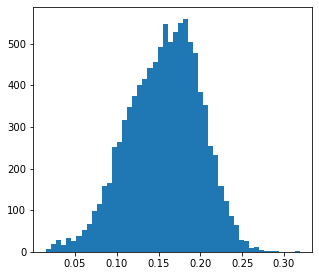

In [10]:
plt.figure(figsize=(5, 4.5))
plt.hist(nnds, bins=50)

### Evaluate quality

##### Calculate Inception metrics

In [10]:
%ls ../checkpoints/

BigGAN-train-2021_04_03_21_38_59/  SAGAN-train-2021_03_12_11_16_43/
BigGAN-train-2021_04_06_13_59_20/  SAGAN-train-2021_03_13_11_47_27/
BigGAN-train-2021_04_06_14_00_18/  SAGAN-train-2021_03_14_12_23_07/
SAGAN-train-2021_03_04_15_20_57/   SAGAN-train-2021_03_15_12_50_35/
SAGAN-train-2021_03_06_00_44_13/   SAGAN-train-2021_03_16_13_20_09/
SAGAN-train-2021_03_06_00_46_59/   SAGAN-train-2021_03_17_13_42_52/
SAGAN-train-2021_03_06_00_48_39/   SAGAN-train-2021_03_18_13_59_54/
SAGAN-train-2021_03_06_00_50_43/   SAGAN-train-2021_03_27_11_48_10/
SAGAN-train-2021_03_06_00_54_20/   SAGAN-train-2021_03_27_11_51_51/
SAGAN-train-2021_03_06_00_57_47/   SAGAN-train-2021_03_27_11_53_44/
SAGAN-train-2021_03_09_00_54_36/   SAGAN-train-2021_03_28_13_20_51/
SAGAN-train-2021_03_09_00_57_09/   SAGAN-train-2021_03_28_13_21_53/
SAGAN-train-2021_03_09_01_00_30/   SAGAN-train-2021_03_28_13_30_23/
SAGAN-train-2021_03_09_02_08_08/   SAGAN-train-2021_04_03_16_07_22/
SAGAN-train-2021_03_10_10_00_29/   SAGAN-train-2

In [11]:
sagan_runs = {
    0.00: ['SAGAN-train-2021_03_04_15_20_57', 'SAGAN-train-2021_03_09_00_54_36', 'SAGAN-train-2021_03_10_10_00_29', 'SAGAN-train-2021_03_17_13_42_52'],
    0.10: ['SAGAN-train-2021_03_06_00_44_13', 'SAGAN-train-2021_03_09_00_57_09', 'SAGAN-train-2021_03_11_10_38_54', 'SAGAN-train-2021_03_18_13_59_54'],
    0.12: ['SAGAN-train-2021_03_06_00_46_59', 'SAGAN-train-2021_03_09_01_00_30', 'SAGAN-train-2021_03_12_11_16_43', 'SAGAN-train-2021_03_28_13_20_51'],
    0.13: ['SAGAN-train-2021_03_06_00_48_39', 'SAGAN-train-2021_03_09_02_08_08', 'SAGAN-train-2021_03_13_11_47_27', 'SAGAN-train-2021_03_28_13_21_53'],
    0.14: ['SAGAN-train-2021_03_06_00_50_43', 'SAGAN-train-2021_03_27_11_48_10', 'SAGAN-train-2021_03_14_12_23_07', 'SAGAN-train-2021_03_28_13_30_23'],
    0.15: ['SAGAN-train-2021_03_06_00_54_20', 'SAGAN-train-2021_03_27_11_51_51', 'SAGAN-train-2021_03_15_12_50_35', 'SAGAN-train-2021_04_03_16_07_22'],
    0.16: ['SAGAN-train-2021_03_06_00_57_47', 'SAGAN-train-2021_03_27_11_53_44', 'SAGAN-train-2021_03_16_13_20_09', 'SAGAN-train-2021_04_03_16_10_52']
}

In [19]:
diffaug_runs = {
    0.00: ['DiffAugGAN(P)-train-2021_03_06_20_15_56', 'DiffAugGAN(P)-train-2021_03_10_09_58_03', 'DiffAugGAN(P)-train-2021_03_25_22_02_38'],
    0.10: ['DiffAugGAN(P)-train-2021_03_06_20_19_47', 'DiffAugGAN(P)-train-2021_03_12_14_55_48', 'DiffAugGAN(P)-train-2021_03_28_03_17_16'],
    0.12: ['DiffAugGAN(P)-train-2021_03_06_20_22_27', 'DiffAugGAN(P)-train-2021_03_14_19_57_50', 'DiffAugGAN(P)-train-2021_03_30_08_38_45'],
    0.13: ['DiffAugGAN(P)-train-2021_03_06_20_25_10', 'DiffAugGAN(P)-train-2021_03_17_01_39_09'],
    0.14: ['DiffAugGAN(P)-train-2021_03_06_20_26_45', 'DiffAugGAN(P)-train-2021_03_19_06_43_02'],
    0.15: ['DiffAugGAN(P)-train-2021_03_08_14_46_12', 'DiffAugGAN(P)-train-2021_03_21_11_38_59'],
    0.16: ['DiffAugGAN(P)-train-2021_03_27_11_52_47', 'DiffAugGAN(P)-train-2021_03_23_16_50_02'],
}

In [12]:
def wrapper(runname):
    if len(glob.glob(f'../checkpoints/{runname}/model=G_ema-best-weights-step=*.pth')) > 0:
        ema_g_path = glob.glob(f'../checkpoints/{runname}/model=G_ema-best-weights-step=*.pth')[0]
    else:
        ema_g_path = glob.glob(f'../checkpoints/{runname}/model=G-best-weights-step=*.pth')[0]
    config_path = f"../src/configs/CIFAR10/{runname.split('-')[0]}.json"
    sampler = misc.construct_sampler(ema_g_path, config_path, device)
    return sampler

In [13]:
def calculate_inception_metrics(samplers, savefig_fname=None):
    
    # sample images
    print('start sampling images..')
    gen_feats = {}
    gen_probs = {}
    for mrt, samplers_ in samplers.items():
        print(f'mrt={mrt}')
        gen_feats[mrt] = []
        gen_probs[mrt] = []
        for sampler in samplers_:
            feats_, probs_ = misc.project(sampler, proj_model, to_numpy=True, return_logits=False)
            gen_feats[mrt].append(feats_)
            gen_probs[mrt].append(probs_)
            
    # calculate inception stats
    print('start calculating inception stats..')
    gen_inception_means, gen_inception_covs = {}, {}
    for mrt, gen_feats_ in gen_feats.items():
        gen_inception_means[mrt] = []
        gen_inception_covs[mrt] = []
        for gen_feat in gen_feats_:
            mu = np.mean(gen_feat, axis=0)
            cov = np.cov(gen_feat, rowvar=False)
            gen_inception_means[mrt].append(mu)
            gen_inception_covs[mrt].append(cov)
            
    # FID
    print('start calculating FID..')
    fids = {}
    for dset_name in feats.keys():
        print(f"{dset_name}:", end=' ')
        fids_ = {}
        for mrt in gen_feats.keys():
            fids_[mrt] = []
            print(mrt, end=', ')
            for mu, cov in zip(gen_inception_means[mrt], gen_inception_covs[mrt]):
                fid = calculate_frechet_distance(mu, cov, dset_inception_means[dset_name], 
                                                 dset_inception_covs[dset_name])
                fids_[mrt].append(fid)
        fids[dset_name] = fids_
        print("")
        
    # IS
    print('start calculating IS..')
    IS_means = {}
    IS_stds = {}
    for mrt, gen_probs_ in gen_probs.items():
        IS_means_, IS_stds_ = [], []
        for prob in gen_probs_:
            IS_mean, IS_std = misc.calculate_IS(prob)
            IS_means_.append(IS_mean)
            IS_stds_.append(IS_std)
        IS_means[mrt], IS_stds[mrt] = np.mean(IS_means_), np.mean(IS_stds_)
    
    # plot
    plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname)
    
    return fids, IS_means, IS_stds

def plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname=None):
    x = np.arange(len(IS_means))  # the label locations
    width = 0.7  # the width of the bars
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for (dset_name, fids_), ax in zip(fids.items(), axs.flat):
        rects = ax.bar(x, [np.mean(fid) for fid in fids_.values()], width,
                       yerr=[np.std(fid) for fid in fids_.values()])

        misc.autolabel(rects, ax)
        ax.set_xticks(x)
        ax.set_xticklabels(list(fids_.keys()))
        ax.set_xlabel('mrt')
        ax.set_title(f"FID ({dset_name})")

    ax = axs.flat[-1]
    rects = ax.bar(x, list(IS_means.values()), width, 
                   label='IS', yerr=list(IS_stds.values()))
    misc.autolabel(rects, ax)
    ax.set_title(f"IS")
    ax.set_xticks(x)
    ax.set_xticklabels(IS_means.keys())
    ax.set_xlabel('mrt')

    plt.tight_layout()
    if savefig_fname is not None:
        if not savefig_fname.endswith('.pdf'):
            savefig_fname += '.pdf'
        plt.savefig(savefig_fname, bbox_inches='tight')

start sampling images..
mrt=0
mrt=0.1
mrt=0.12
mrt=0.13
mrt=0.14
mrt=0.15
mrt=0.16
start calculating inception stats..
start calculating FID..
cifar10_1: 0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifar10_train: 0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifar10_test: 0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifair10: 0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
start calculating IS..


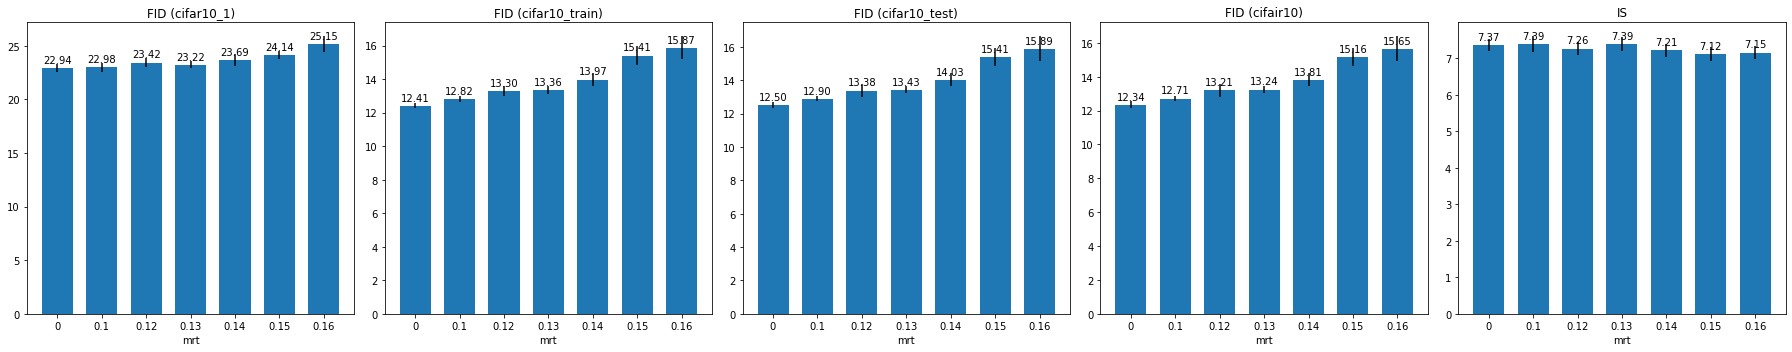

In [14]:
# SAGAN experiments (run in cl8)
runs = sagan_runs
samplers = {mrt: [wrapper(runname) for runname in runs[mrt]]
            for mrt in [0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16]}
fids, IS_means, IS_stds = calculate_inception_metrics(samplers)

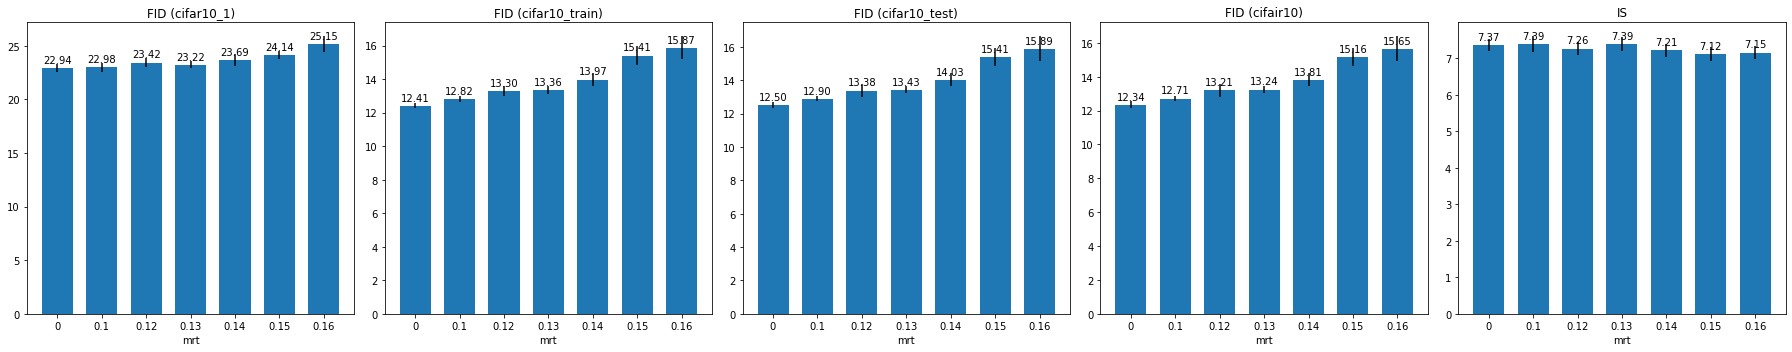

In [15]:
plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname='custom_inception_metrics(cifar10_sagan).pdf')

In [ ]:
# diffaug experiments (run on cl7)
runs = diffaug_runs
samplers = {mrt: [wrapper(runname) for runname in runs[mrt]]
            for mrt in [0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16]}
fids, IS_means, IS_stds = calculate_inception_metrics(samplers)

##### Save sampled images
skip this for now too many images to visualize

In [19]:
bsize = 50
memdists, memdist_indices = {}, {}

for mrt, activations in sampled_inception_activations.items():
    activations_ = activations[0] # only use seed = 0
    memdists_, memdist_indices_ = [], []
    for bstart in range(0, len(activations_['pool']), bsize):
        batch = activations_['pool'][bstart:bstart + bsize]
        batch = torch.from_numpy(batch).float().to(device)
        with torch.no_grad():
            memdist, memdist_index = misc.compute_memorization_distance(batch, real_normed_tensor)
        memdists_.append(memdist.cpu().numpy())
        memdist_indices_.append(memdist_index.cpu().numpy())
    memdists[mrt] = np.concatenate(memdists_, axis=0)
    memdist_indices[mrt] = np.concatenate(memdist_indices_, axis=0)

In [22]:
# random 400 samples, 40 per class (20 x 2)
n_rows, n_cols = 20, 20
padding = 4
n_rows_per_class, n_cols_per_class = 2, 20

for mrt, activations in sampled_inception_activations.items():
    for seed, activations_ in activations.items():
        combined_image = np.zeros([n_rows * 32 + (n_rows - 1) * padding,
                                   n_cols * 32 + (n_cols - 1) * padding,
                                   3])

        for n_class in range(10):

            class_sampled_images = activations_['images'][activations_['labels'] == n_class]
            assert(len(class_sampled_images) >= n_rows_per_class * n_cols_per_class)

            class_sampled_images = class_sampled_images[:n_rows_per_class * n_cols_per_class]

            for cnt, class_sampled_image in enumerate(class_sampled_images):
                start_x = (cnt // n_rows) * (32 + padding) + n_class * (32 + padding) * n_rows_per_class
                start_y = (cnt % n_rows) * (32 + padding)
                combined_image[start_x:start_x + 32, start_y:start_y + 32] = class_sampled_image.transpose(1, 2, 0)

        plt.figure(figsize=(60, 31))
        plt.imshow(combined_image)
        plt.axis('off')
        # plt.savefig(f'image_samples/random_samples/mrt={mrt:.2f}seed{seed}.pdf', bbox_inches='tight')
        plt.close()

In [23]:
for mrt, activations in sampled_inception_activations.items():
    
    for seed, activations_ in activations.items():
    
        combined_images = {}

        for n_class in range(10):
            class_mask = activations_['labels'] == n_class
            class_sampled_images = activations_['images'][class_mask]

            n_rows, n_cols = 7, 7
            padding = 4
            combined_image = np.zeros([n_rows * 32 + (n_rows - 1) * padding,
                                       2 * n_cols * 32 + (n_cols - 1) * padding,
                                       3])
            assert(len(class_sampled_images) >= n_rows * n_cols)

            rank_mask = memdists[mrt][class_mask].argsort().argsort() < n_rows * n_cols
            top_n_indices = np.arange(len(rank_mask)).astype(np.int)[rank_mask]
            top_n_nn_indices = memdist_indices[mrt][class_mask].astype(np.int)[rank_mask]
            assert(len(list(set(top_n_indices))) == len(list(top_n_nn_indices)))

            for cnt, (image_i, nn_i) in enumerate(zip(top_n_indices, top_n_nn_indices)):
                start_x = (cnt % n_rows) * (32 + padding)
                start_y = (cnt // n_rows) * (32 * 2 + padding)

                image = class_sampled_images[image_i].transpose(1, 2, 0)
                nn_image = cifar10_train_dset[nn_i][0].numpy().transpose(1, 2, 0)

                combined_image[start_x:start_x + 32, start_y:start_y + 32] = image
                combined_image[start_x:start_x + 32, start_y + 32:start_y + 64] = (nn_image + 1) / 2

            combined_images[n_class] = combined_image

        fig, axs = plt.subplots(2, 5, figsize=(300, 62))
        for n_class, ax in zip(range(10), axs.flat):
            ax.imshow(combined_images[n_class])
            ax.axis('off')
        plt.tight_layout()
        # plt.savefig(f'image_samples/nearest_neighbor_pairs/mrt={mrt:.2f}seed{seed}.pdf', bbox_inches='tight')
        plt.close()

### Evaluate memorization

###### Calculate C_T

In [24]:
class_stats = {}
for n_class in range(10):
    print(f"n_class = {n_class}")
    train_pool = ref_activations['cifar10_train']['pool'][ref_activations['cifar10_train']['labels'] == n_class]
    pca_xf = PCA(n_components=64).fit(train_pool)
    train_pca = pca_xf.transform(train_pool)
    
    stats = {}
    
    for dset_name, ref_activation in ref_activations.items():

        if dset_name == 'cifar10_train':
            continue
        
        n_clusters = min(ref_activation['pool'].shape[0], train_pool.shape[0]) // 200
        km_clf = KMeans(n_clusters=n_clusters).fit(train_pca)
        T_labels = km_clf.predict(train_pca)
        
        test_pool = ref_activation['pool'][ref_activation['labels'] == n_class]
        test_pca = pca_xf.transform(test_pool)
        Pn_labels = km_clf.predict(test_pca)
        
        C_Ts = {}
        
        for mrt, sampled_activations in sampled_inception_activations.items():
            for seed, sampled_activation in sampled_activations.items():
                gen_pool = sampled_activation['pool'][sampled_activation['labels'] == n_class]
                gen_pca = pca_xf.transform(gen_pool)
                Qm_labels = km_clf.predict(gen_pca)
                # Qm_labels = km_clf.predict(sampled_pool)

                # C_T = data_copying_tests.C_T(test_pca, Pn_labels, gen_pca, Qm_labels, 
                #                              train_pca, T_labels, tau=20 / len(gen_pca))
                C_T = data_copying_tests.C_T(test_pool, Pn_labels, gen_pool, Qm_labels, 
                                             train_pool, T_labels, tau=20 / len(gen_pool))
                if mrt not in C_Ts:
                    C_Ts[mrt] = [C_T]
                else:
                    C_Ts[mrt].append(C_T)
        stats_ = {mrt: {'C_T_mean': np.mean(C_Ts_), 'C_T_std': np.std(C_Ts_)}
                  for mrt, C_Ts_ in C_Ts.items()}

        stats[dset_name] = stats_
        
    class_stats[n_class] = stats

n_class = 0
n_class = 1
cell 21 unrepresented by Qm
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9


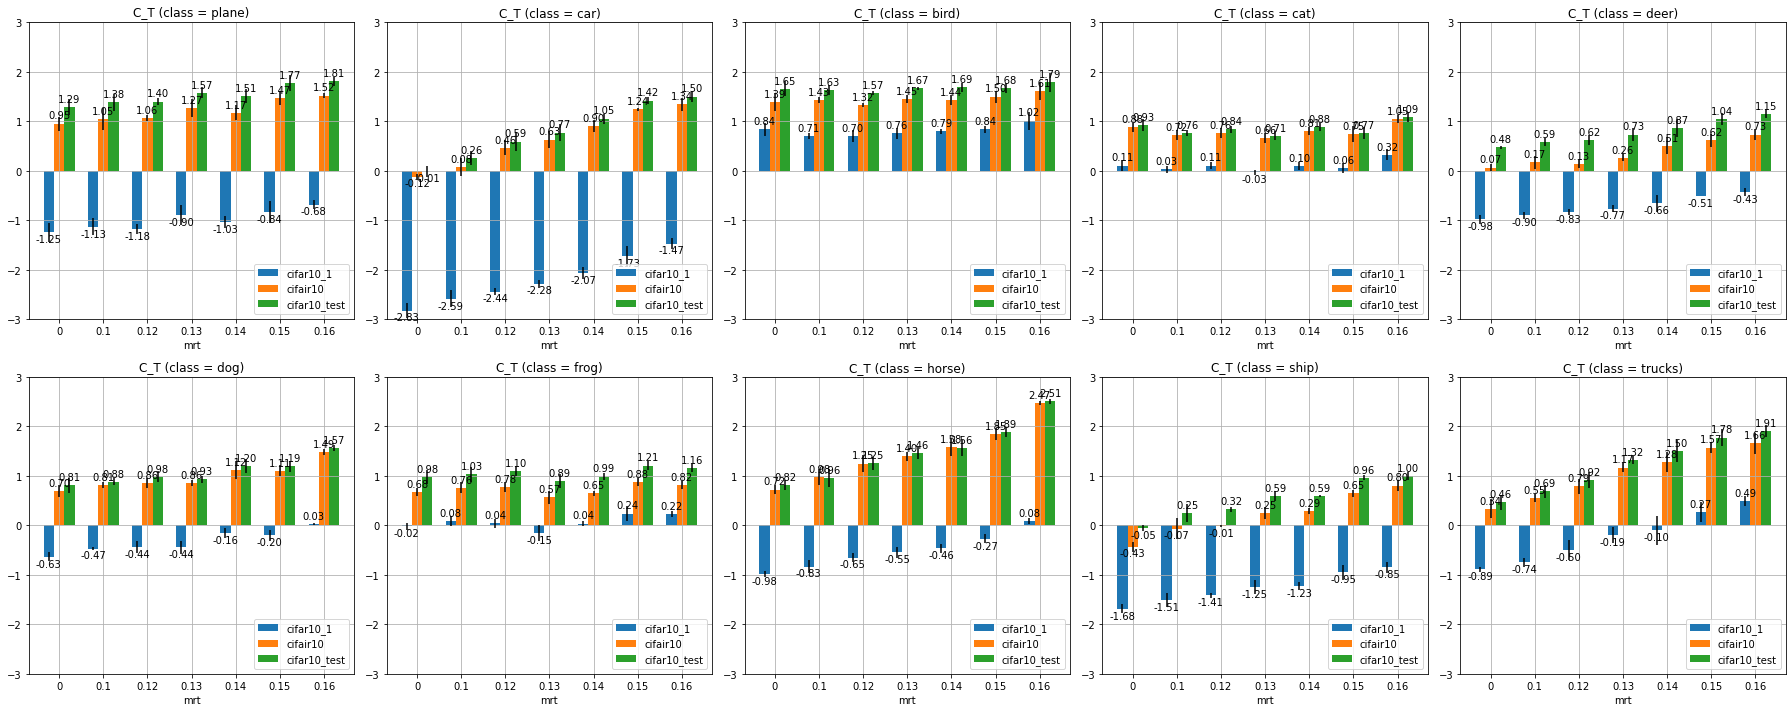

In [28]:
ordered_dsets = ['cifar10_1', 'cifair10', 'cifar10_test']
n_dset = len(ordered_dsets)

x = np.arange(len(sampled_inception_activations))  # the label locations
width = 0.7 / n_dset  # the width of the bars
x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

fig, axs = plt.subplots(2, 5, figsize=(25, 10))


for ax, (n_class, stats) in zip(axs.flat, class_stats.items()):

    for x_shift, dset_name in zip(x_shifts, ordered_dsets):
        stats_ = stats[dset_name] 
        rects = ax.bar(x + x_shift, [v['C_T_mean'] for mrt, v in stats_.items()], width,
                       yerr=[v['C_T_std'] for mrt, v in stats_.items()], label=dset_name)

        misc.autolabel(rects, ax)
        ax.set_xticks(x)
        ax.set_xticklabels([mrt for mrt in stats_.keys()])
        ax.set_title(f"C_T (class = {cifar10_classnames[n_class]})")
        
    ax.set_xlabel('mrt')
    ax.set_ylim(-3, 3)
    ax.legend(loc='lower right')
    ax.grid()

plt.tight_layout()
# plt.savefig('data_copying_metrics(mrts).pdf', bbox_inches='tight')

###### Calculate LOO_NN_acc

In [58]:
def NN_test(T, Qm, device, bsize=50):
    if T.shape[0] > Qm.shape[0]:
        T = T[np.random.choice(T.shape[0], Qm.shape[0], replace=False)]
    else:
        Qm = Qm[:T.shape[0]]
    # requires same size
    cat_tensor = torch.from_numpy(np.concatenate([T, Qm], axis=0)).float().to(device)
    cat_tensor = torch.div(cat_tensor, 
                           torch.norm(cat_tensor, dim=1).view(-1, 1))
    
    # T wrt Qm
    n_correct, n_total = 0, 0
    for bstart in range(0, T.shape[0], bsize):
        with torch.no_grad():
            T_tensor = cat_tensor[bstart:bstart + bsize]
            _, mdi = misc.compute_memorization_distance(T_tensor, cat_tensor, k=2)
            n_correct += (mdi.cpu().numpy() < T.shape[0]).sum()
            n_total += mdi.shape[0]
    acc_T = n_correct / n_total
    
    # Qm wrt T
    n_correct, n_total = 0, 0
    for bstart in range(0, Qm.shape[0], bsize):
        with torch.no_grad():
            Qm_tensor = cat_tensor[T.shape[0] + bstart:T.shape[0] + bstart + bsize]
            _, mdi = misc.compute_memorization_distance(Qm_tensor, cat_tensor, k=2)
            n_correct += (mdi.cpu().numpy() >= T.shape[0]).sum()
            n_total += mdi.shape[0]
    acc_Qm = n_correct / n_total
    
    return acc_T, acc_Qm

In [59]:
acc_stats = {}
for n_class in range(10):
    train_pool = ref_activations['cifar10_train']['pool'][ref_activations['cifar10_train']['labels'] == n_class]
    
    acc_Ts, acc_Qms = {}, {}
        
    for mrt, sampled_activations in sampled_inception_activations.items():
        for seed, sampled_activation in sampled_activations.items():
            gen_pool = sampled_activation['pool'][sampled_activation['labels'] == n_class]
            acc_T, acc_Qm = NN_test(train_pool, gen_pool, device)
            
            if mrt not in acc_Ts or mrt not in acc_Qms:
                acc_Ts[mrt] = [acc_T]
                acc_Qms[mrt] = [acc_Qm]
            else:
                acc_Ts[mrt].append(acc_T)
                acc_Qms[mrt].append(acc_Qm)
    stats = {mrt: {'acc_T_mean': np.mean(acc_Ts[mrt]), 'acc_T_std': np.std(acc_Ts[mrt]),
                   'acc_Qm_mean': np.mean(acc_Qms[mrt]), 'acc_Qm_std': np.std(acc_Qms[mrt])}
             for mrt in sampled_inception_activations.keys()}
    acc_stats[n_class] = stats

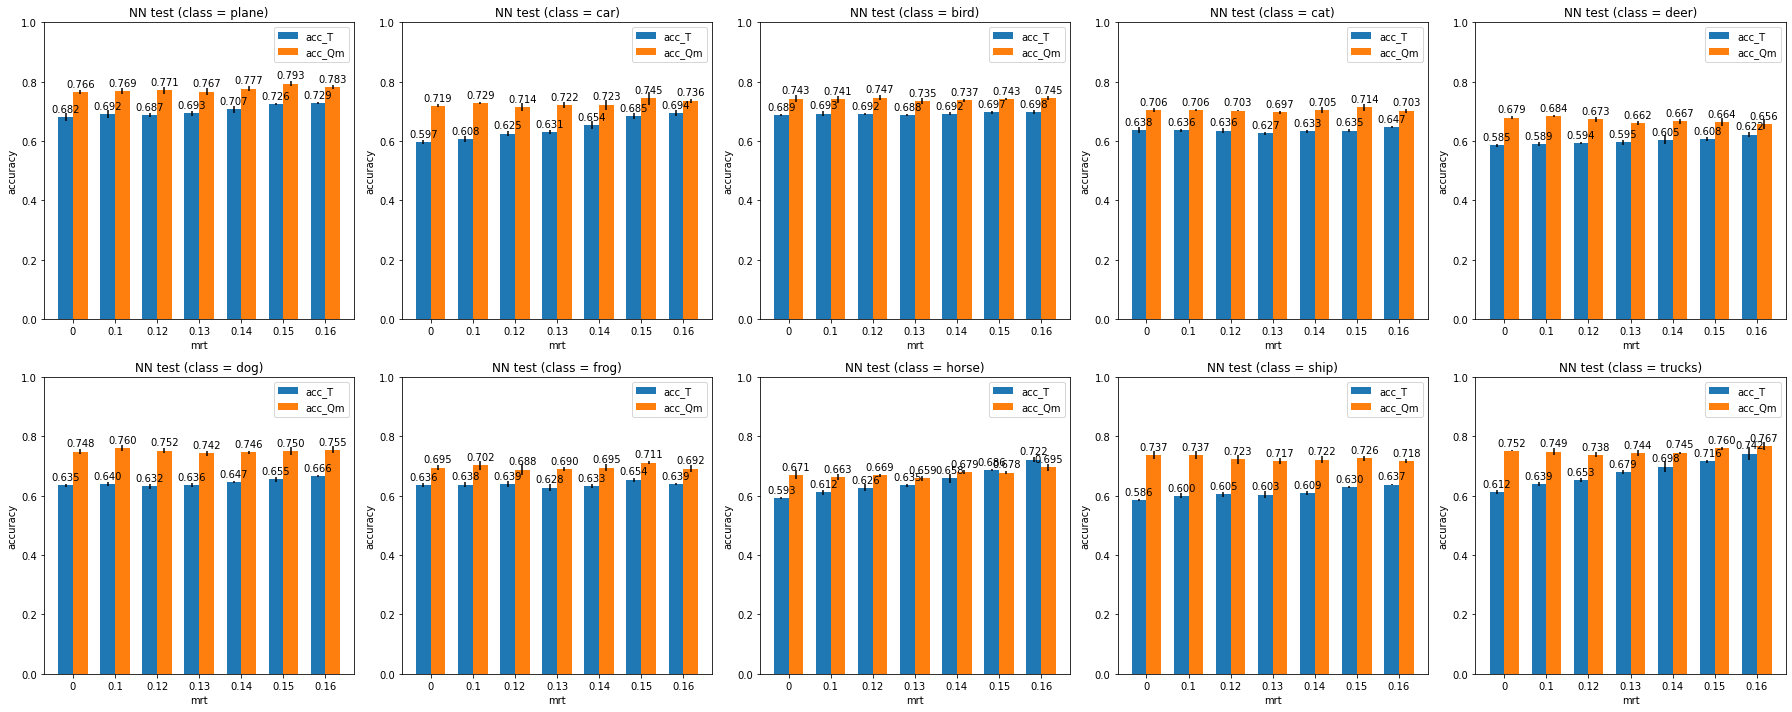

In [65]:
n_dset = 2

x = np.arange(len(sampled_inception_activations))  # the label locations
width = 0.7 / n_dset  # the width of the bars
x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (n_class, stats) in zip(axs.flat, acc_stats.items()):
    for x_shift, metric in zip(x_shifts, ['acc_T', 'acc_Qm']):
        rects = ax.bar(x + x_shift, [v[f'{metric}_mean'] for mrt, v in stats.items()], width,
                       yerr=[v[f'{metric}_std'] for mrt, v in stats.items()], label=metric)

        misc.autolabel(rects, ax, n_digits=3)
        ax.set_xticks(x)
        ax.set_xticklabels([mrt for mrt in stats.keys()])
        ax.set_title(f"NN test (class = {cifar10_classnames[n_class]})")
        
    ax.set_xlabel('mrt')
    ax.set_ylabel('accuracy')
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()
# plt.savefig('nn_test_metrics(mrts).pdf', bbox_inches='tight')

###### Calculate NND

In [114]:
def parse_line(line):
    _, t_str, nnd_str, _, time_str = line.split(' ')
    t = float(t_str.split('=')[-1][:-1])
    nnd = float(nnd_str.split('=')[-1][:-1])
    time = float(time_str.split('=')[-1])
    nnd_data = {'t': t, 'nnd': nnd, 'time': time}
    return nnd_data

In [95]:
nnds_stats, times_stats = {}, {}
for dset_name in ['cifar10_1', 'cifar10_valid']:
    nnds = {mrt: [] for mrt in sampled_inception_activations.keys()}
    times = {mrt: [] for mrt in sampled_inception_activations.keys()}
    for seed in [0, 66, 1126, 3120]:
        with open(f'nnd_logs/umr_{dset_name}_seed0_load_seed{seed}.txt', 'r') as f:
            lines = f.readlines()
        for line in lines:
            nnd_data = parse_line(line)
            nnds[nnd_data['t']].append(nnd_data['nnd'])
            times[nnd_data['t']].append(nnd_data['time'])
    nnds_stats[dset_name] = nnds
    times_stats[dset_name] = times

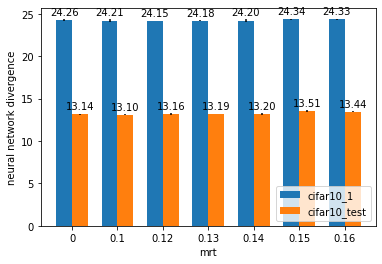

In [117]:
n_dset = len(nnds_stats)

x = np.arange(len(sampled_inception_activations))  # the label locations
width = 0.7 / n_dset  # the width of the bars
x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

for x_shift, (dset_name, stats) in zip(x_shifts, nnds_stats.items()):
    
    nnd_mean = [np.mean(v) for v in stats.values()]
    nnd_std = [np.std(v) for v in stats.values()]
    rects = plt.bar(x + x_shift, nnd_mean, width, yerr=nnd_std, 
                    label=dset_name.replace('valid', 'test'))

    misc.autolabel(rects, plt)
    plt.xticks(x, labels=[mrt for mrt in stats.keys()])
plt.xlabel('mrt')
plt.ylabel('neural network divergence')
plt.legend(loc='lower right')
    
# plt.savefig('nnd_values(mrts).pdf', bbox_inches='tight')

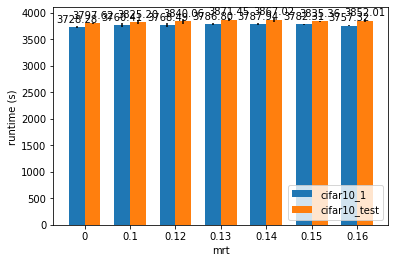

In [116]:
n_dset = len(nnds_stats)

x = np.arange(len(sampled_inception_activations))  # the label locations
width = 0.7 / n_dset  # the width of the bars
x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

for x_shift, (dset_name, stats) in zip(x_shifts, times_stats.items()):
    
    nnd_mean = [np.mean(v) for v in stats.values()]
    nnd_std = [np.std(v) for v in stats.values()]
    rects = plt.bar(x + x_shift, nnd_mean, width, yerr=nnd_std, 
                    label=dset_name.replace('valid', 'test'))

    misc.autolabel(rects, plt)
    plt.xticks(x, labels=[mrt for mrt in stats.keys()])
plt.xlabel('mrt')
plt.ylabel('runtime (s)')
plt.legend(loc='lower right')
    
# plt.savefig('nnd_times(mrts).pdf', bbox_inches='tight')